In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go


# data

In [5]:
def get_prices(round: int, day: int):

    path = f"../../data/round{round}/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"../../data/round{round}/trades_round_{round}_day_{day}.csv"
    return pd.read_csv(path, sep=";")

price_frames = []
trade_frames = []

for day in range(0, 1):  

    prices = get_prices(3, day)
    trades = get_trades(3, day)
    price_frames.append(prices)
    trade_frames.append(trades)

all_prices = pd.concat(price_frames, ignore_index=True)
all_trades = pd.concat(trade_frames, ignore_index=True)




In [7]:
all_prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0,999900,VOLCANIC_ROCK_VOUCHER_10250,277.0,7.0,NaN,NaN,NaN,NaN,278,18,NaN,NaN,NaN,NaN,277.5,0.0
139996,0,999900,JAMS,6541.0,183.0,NaN,NaN,NaN,NaN,6543,183,NaN,NaN,NaN,NaN,6542.0,0.0
139997,0,999900,VOLCANIC_ROCK_VOUCHER_10000,515.0,7.0,NaN,NaN,NaN,NaN,517,18,NaN,NaN,NaN,NaN,516.0,0.0
139998,0,999900,DJEMBES,13409.0,64.0,NaN,NaN,NaN,NaN,13410,64,NaN,NaN,NaN,NaN,13409.5,0.0


In [9]:
def black_scholes_call(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = (spot * norm.cdf(d1) - strike * norm.cdf(d2))
    return call_price


def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)

def gamma(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1)/(spot * volatility * np.sqrt(time_to_expiry))

def vega(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

def implied_volatility(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    try:
        # Use Brent's method to find the implied volatility
        iv = brentq(equation, 1e-10, 5.0, xtol=1e-10)
        return iv
    except ValueError:
        # If no valid volatility can be found, return None
        return None

In [11]:
rock_prices = all_prices[all_prices["product"] == "VOLCANIC_ROCK"][["day", "timestamp", "mid_price"]]
rock_prices["log_return"] = np.log(rock_prices["mid_price"] / rock_prices["mid_price"].shift(1))
rock_prices = rock_prices.rename(columns={"mid_price": "spot_price"})

vol_window = 10  
rock_prices["volatility"] = rock_prices["log_return"].rolling(window=vol_window).std()


voucher_products = [
    "VOLCANIC_ROCK_VOUCHER_9500",
    "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000",
    "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]
df_vouchers = all_prices[all_prices["product"].isin(voucher_products)].copy()

df_vouchers = df_vouchers.merge(rock_prices, on=["day", "timestamp"], how="left")

df_vouchers["total_bid_volume"] = df_vouchers[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].sum(axis=1)
df_vouchers["total_ask_volume"] = df_vouchers[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].sum(axis=1)
df_vouchers["total_depth"] = df_vouchers["total_bid_volume"] + df_vouchers["total_ask_volume"]

voucher_params = {
    "VOLCANIC_ROCK_VOUCHER_9500": {"strike": 9500, "time_to_expiry": 5/250},
    "VOLCANIC_ROCK_VOUCHER_9750": {"strike": 9750, "time_to_expiry": 5/250},
    "VOLCANIC_ROCK_VOUCHER_10000": {"strike": 10000, "time_to_expiry": 5/250},
    "VOLCANIC_ROCK_VOUCHER_10250": {"strike": 10250, "time_to_expiry": 5/250},
    "VOLCANIC_ROCK_VOUCHER_10500": {"strike": 10500, "time_to_expiry": 5/250},
}

df_vouchers = df_vouchers.rename(columns={"mid_price": "call_price"})
df_vouchers = df_vouchers[['product', 'timestamp', 'call_price', 'spot_price', 'volatility', 'total_bid_volume', 'total_ask_volume', 'total_depth']]

In [13]:
def compute_implied_volatility(row):
    params = voucher_params[row["product"]]
    spot = row["spot_price"]
    call_price = row["call_price"]
    if pd.isna(spot) or pd.isna(call_price) or spot <= 0 or call_price <= 0:
        return None
    iv = implied_volatility(
        call_price = call_price,
        spot = spot,
        strike=params["strike"],
        time_to_expiry=params["time_to_expiry"]
        )
    return iv

df_vouchers["implied_volatility"] = df_vouchers.apply(compute_implied_volatility, axis=1)

In [14]:
def compute_fair_price(row):
    params = voucher_params[row["product"]]
    spot = row["spot_price"]
    if pd.isna(spot):  
        return None
    return black_scholes_call(
        spot=spot,
        strike=params["strike"],
        time_to_expiry=params["time_to_expiry"],
        volatility=row["volatility"]
        )
df_vouchers["fair_price"] = df_vouchers.apply(compute_fair_price, axis=1)

In [15]:
df_vouchers

,product,timestamp,call_price,spot_price,volatility,total_bid_volume,total_ask_volume,total_depth,implied_volatility,fair_price
0,VOLCANIC_ROCK_VOUCHER_10500,0,99.5,10503.0,NaN,19.0,19.0,38.0,0.165397,NaN
1,VOLCANIC_ROCK_VOUCHER_10000,0,505.5,10503.0,NaN,19.0,19.0,38.0,0.177945,NaN
2,VOLCANIC_ROCK_VOUCHER_9750,0,754.5,10503.0,NaN,19.0,19.0,38.0,0.235596,NaN
3,VOLCANIC_ROCK_VOUCHER_9500,0,1003.5,10503.0,NaN,19.0,19.0,38.0,0.269462,NaN
4,VOLCANIC_ROCK_VOUCHER_10250,0,273.5,10503.0,NaN,19.0,19.0,38.0,0.170782,NaN
...,...,...,...,...,...,...,...,...,...,...
49995,VOLCANIC_ROCK_VOUCHER_9500,999900,1013.5,10514.0,0.000145,18.0,29.0,47.0,NaN,1014.0
49996,VOLCANIC_ROCK_VOUCHER_9750,999900,764.5,10514.0,0.000145,7.0,18.0,25.0,0.208575,764.0
49997,VOLCANIC_ROCK_VOUCHER_10500,999900,94.5,10514.0,0.000145,7.0,18.0,25.0,0.147308,14.0
49998,VOLCANIC_ROCK_VOUCHER_10250,999900,277.5,10514.0,0.000145,7.0,18.0,25.0,0.153835,264.0


In [16]:
# Calculate mean and standard deviation of volatility for each product
volatility_stats = df_vouchers.groupby('product')['implied_volatility'].agg(['mean', 'std']).reset_index()

# Print the mean and standard deviation of volatility for each product
print("Mean and Standard Deviation of Volatility for Each Option:")
print(volatility_stats)

Mean and Standard Deviation of Volatility for Each Option:
                       product      mean       std
0  VOLCANIC_ROCK_VOUCHER_10000  0.174124  0.007581
1  VOLCANIC_ROCK_VOUCHER_10250  0.158651  0.004627
2  VOLCANIC_ROCK_VOUCHER_10500  0.154997  0.005499
3   VOLCANIC_ROCK_VOUCHER_9500  0.152193  0.127426
4   VOLCANIC_ROCK_VOUCHER_9750  0.183454  0.062167


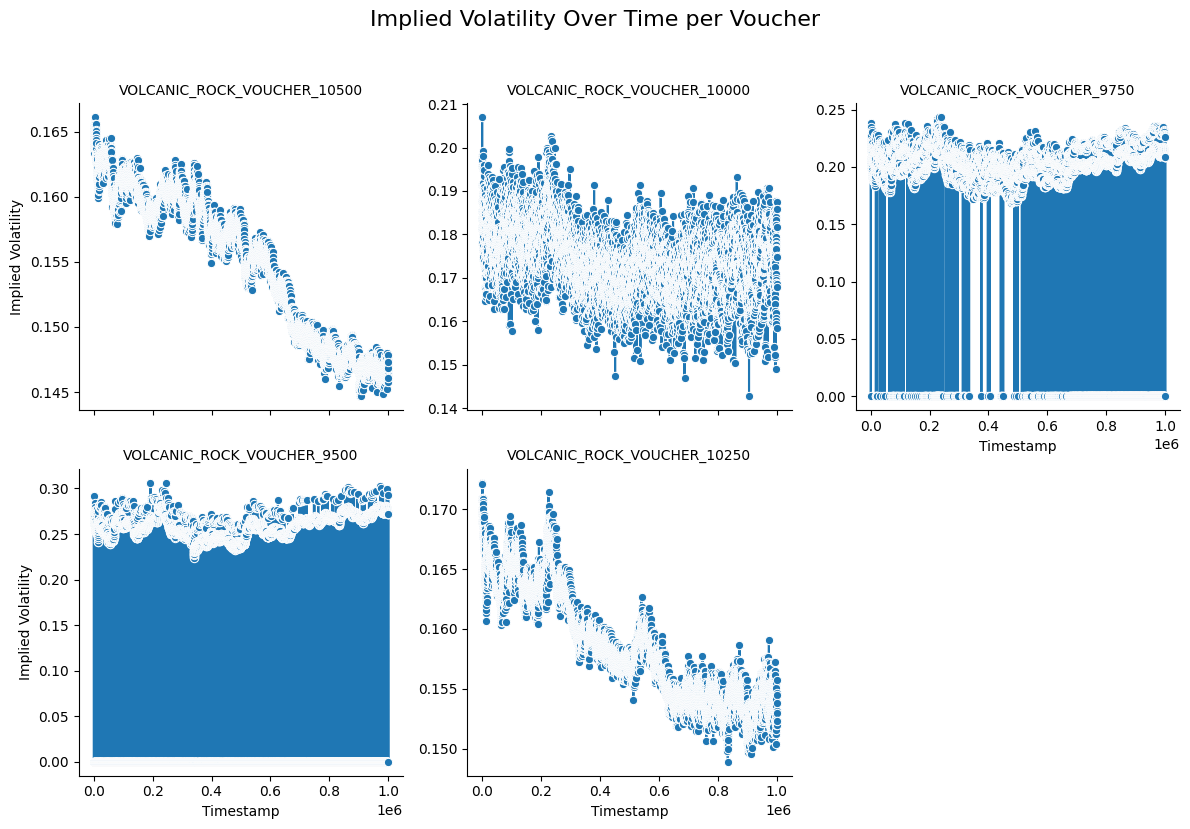

In [17]:
g = sns.FacetGrid(df_vouchers, col="product", col_wrap=3, height=4, sharey=False)

g.map_dataframe(sns.lineplot, x="timestamp", y="implied_volatility", marker="o")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Timestamp", "Implied Volatility")
g.fig.suptitle("Implied Volatility Over Time per Voucher", y=1.03, fontsize=16)

plt.tight_layout()
plt.show()

In [36]:
df_vouchers[df_vouchers['product'] == "VOLCANIC_ROCK_VOUCHER_10000"]['implied_volatility'].value_counts()

implied_volatility
0.172750    32
0.173618    31
0.176474    30
0.169643    28
0.174485    28
            ..
0.180200     1
0.172511     1
0.168395     1
0.169154     1
0.168664     1
Name: count, Length: 2187, dtype: int64

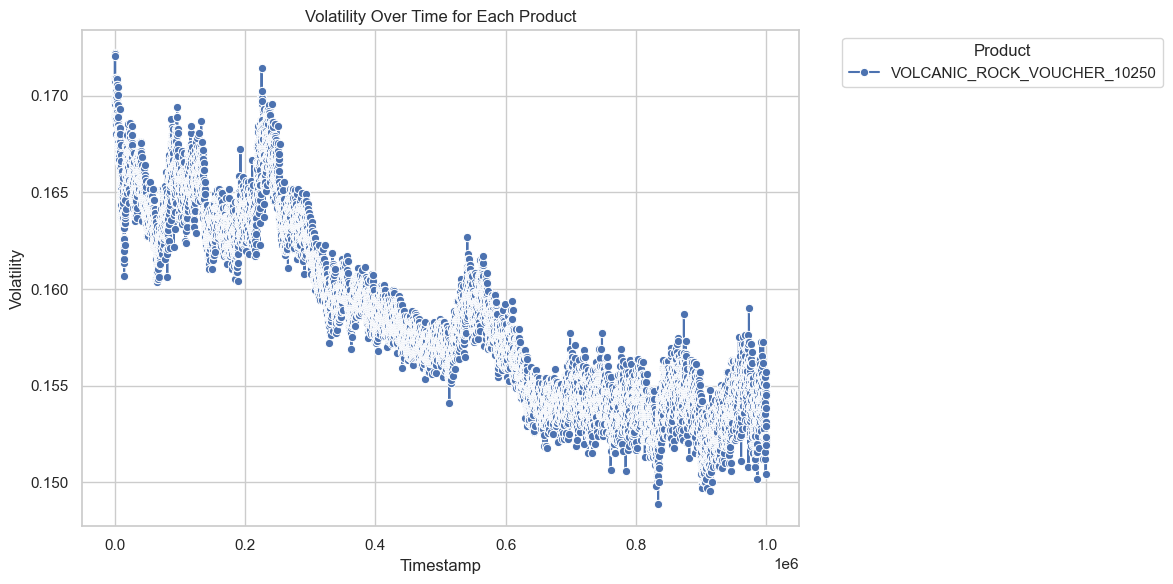

In [23]:
# Set up the seaborn style
sns.set(style="whitegrid")

# 1. Line plot for volatility over time for each product
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_vouchers[df_vouchers['product'] == "VOLCANIC_ROCK_VOUCHER_10250"], x='timestamp', y='implied_volatility', hue='product', marker='o')
plt.title('Volatility Over Time for Each Product')
plt.xlabel('Timestamp')
plt.ylabel('Volatility')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


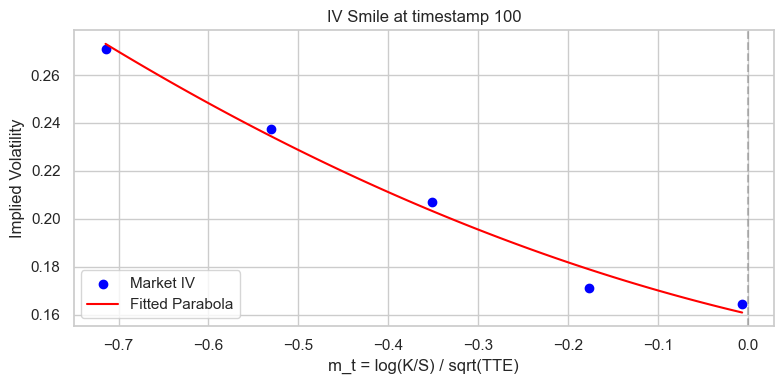

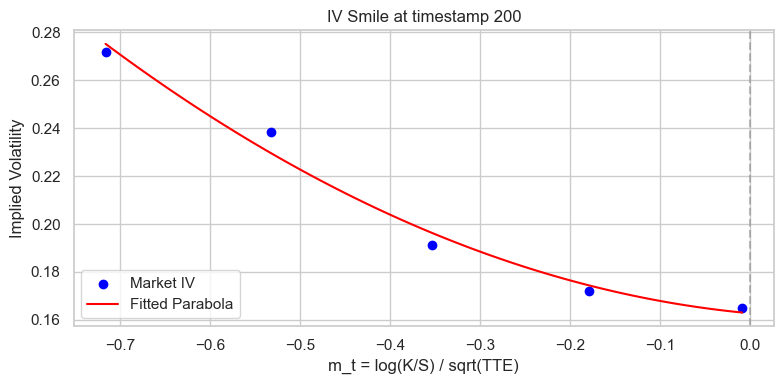

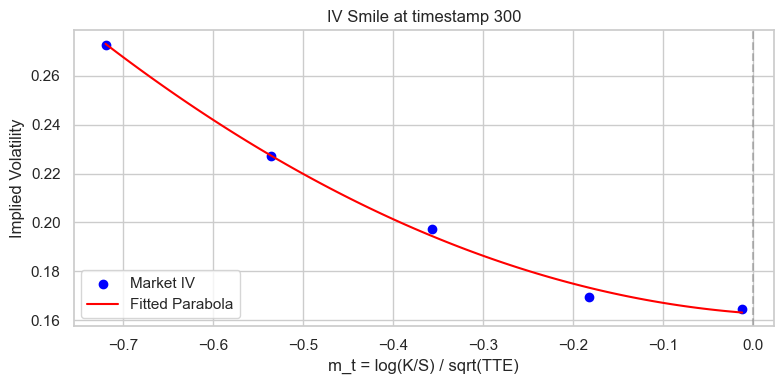

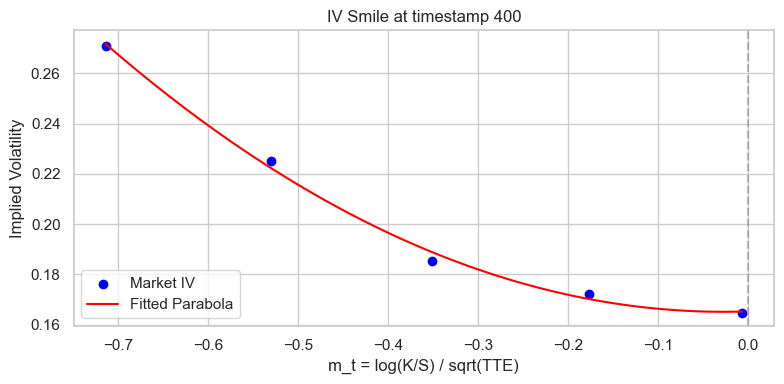

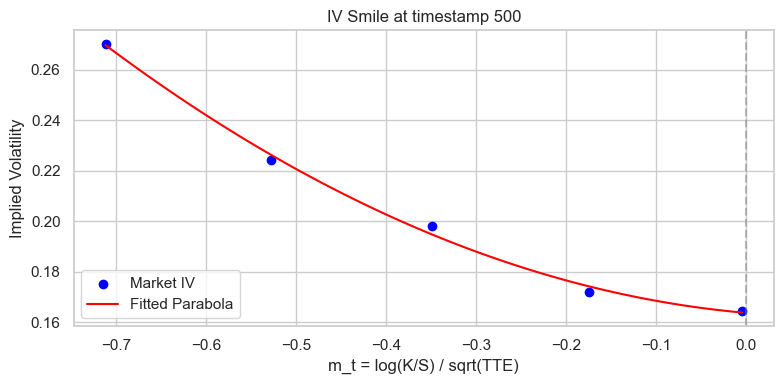

In [154]:
timestamps_to_plot = filtered_df["timestamp"].unique()[::2000] 
timestamps_to_plot = np.array([100,200,300,400,500])
for ts in timestamps_to_plot:
    slice_df = filtered_df[filtered_df["timestamp"] == ts]
    if len(slice_df) < 3:
        continue  

    x = slice_df["m_t"].values
    y = slice_df["implied_volatility"].values

    coeffs = np.polyfit(x, y, deg=2)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = poly(x_fit)
    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, label="Market IV", color="blue")
    plt.plot(x_fit, y_fit, label="Fitted Parabola", color="red")
    plt.axvline(0, linestyle="--", color="gray", alpha=0.5)
    plt.title(f"IV Smile at timestamp {ts}")
    plt.xlabel("m_t = log(K/S) / sqrt(TTE)")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [114]:
filtered_df.head(60)

,product,timestamp,call_price,spot_price,volatility,total_bid_volume,total_ask_volume,total_depth,implied_volatility,fair_price,strike,TTE,m_t
0,VOLCANIC_ROCK_VOUCHER_10500,0,99.5,10503.0,NaN,19.0,19.0,38.0,0.165397,NaN,10500,0.02,-0.002020
1,VOLCANIC_ROCK_VOUCHER_10000,0,505.5,10503.0,NaN,19.0,19.0,38.0,0.177945,NaN,10000,0.02,-0.347019
2,VOLCANIC_ROCK_VOUCHER_9750,0,754.5,10503.0,NaN,19.0,19.0,38.0,0.235596,NaN,9750,0.02,-0.526043
3,VOLCANIC_ROCK_VOUCHER_9500,0,1003.5,10503.0,NaN,19.0,19.0,38.0,0.269462,NaN,9500,0.02,-0.709717
4,VOLCANIC_ROCK_VOUCHER_10250,0,273.5,10503.0,NaN,19.0,19.0,38.0,0.170782,NaN,10250,0.02,-0.172415
5,VOLCANIC_ROCK_VOUCHER_10000,100,515.5,10510.0,NaN,13.0,13.0,26.0,0.207007,NaN,10000,0.02,-0.351730
6,VOLCANIC_ROCK_VOUCHER_10250,100,279.5,10510.0,NaN,13.0,13.0,26.0,0.170933,NaN,10250,0.02,-0.177127
7,VOLCANIC_ROCK_VOUCHER_10500,100,102.5,10510.0,NaN,13.0,13.0,26.0,0.164373,NaN,10500,0.02,-0.006731
8,VOLCANIC_ROCK_VOUCHER_9750,100,761.5,10510.0,NaN,13.0,13.0,26.0,0.237410,NaN,9750,0.02,-0.530754
9,VOLCANIC_ROCK_VOUCHER_9500,100,1010.5,10510.0,NaN,13.0,13.0,26.0,0.271051,NaN,9500,0.02,-0.714428


<Axes: >

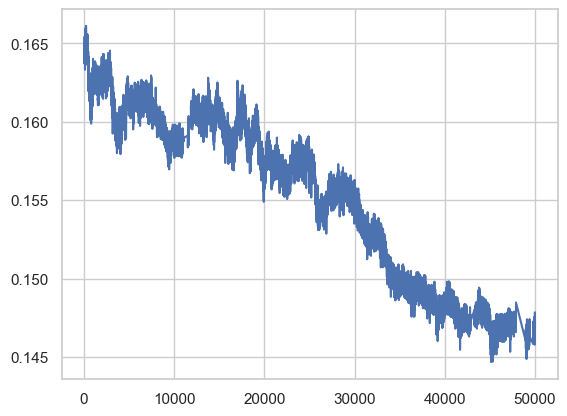

In [138]:
filtered_df[filtered_df["m_t"] > -0.02]["implied_volatility"].plot()


<Axes: >

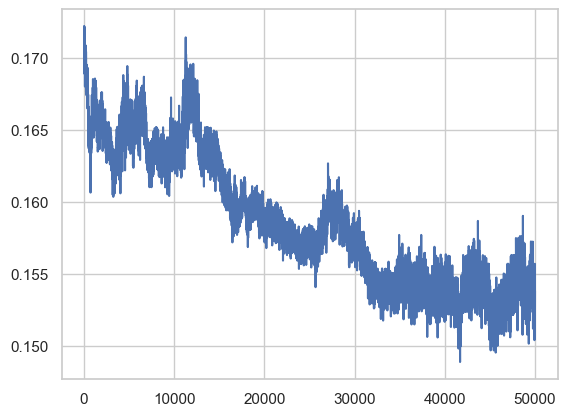

In [158]:
filtered_df[filtered_df["strike"]==10250]["implied_volatility"].plot()


In [162]:
filtered_df.to_csv("data.csv", index=False)